In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting, y_bar=2., ϵ=1.)

Converged. Total iteration 5000: LHS Error: 4.183515303690655e-05; RHS Error 9.117047385512334e-05
Converged. Total iteration 1507: LHS Error: 9.965610114903711e-09; RHS Error 0.00047002697355678913
Converged. Total iteration 1621: LHS Error: 9.952280777270062e-09; RHS Error 0.0022788046860334884
Converged. Total iteration 443: LHS Error: 9.764197450579104e-09; RHS Error 0.0008703168687622803


In [20]:
# Simulation. 1.0
et_list = []
yt_list = []
for temp in model_i:
    et, yt, _, _ = simulation(temp['y_grid'], temp['e_tilde'], temp['h'],
                              np.zeros_like(temp['e_tilde']).reshape(1, -1),
                              θ=np.mean(model['θ']), y_start=1., T=90)
    et_list.append(et)
    yt_list.append(yt)

In [21]:
# Simulation, 1.1
et_list_new = []
yt_list_new = []
for temp in model_i:
    et, yt, _, _ = simulation(temp['y_grid'], temp['e_tilde'], temp['h'],
                              np.zeros_like(temp['e_tilde']).reshape(1, -1),
                              θ=np.mean(model['θ']), y_start=1.1, T=90)
    et_list_new.append(et)
    yt_list_new.append(yt)

In [2]:
@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [22]:
SCCt_list = [η*(0.025)*Kt[:91]/((1.-η)*et) * 1000 for et in et_list]
SCCt_list_new = [η*(0.025)*Kt[:91]/((1.-η)*et) * 1000 for et in et_list_new]

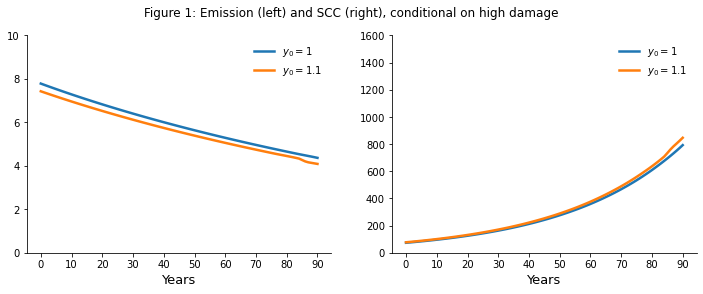

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(et_list[1], label=r'$y_0=1$', linewidth=2.5)
ax1.plot(et_list_new[1], label=r'$y_0=1.1$', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0, 10)

ax2.plot(SCCt_list[1], label=r'$y_0=1$', linewidth=2.5)
ax2.plot(SCCt_list_new[1], label=r'$y_0=1.1$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.legend(frameon=False)
ax2.set_ylim(0, 1600)

ax1.set_xticks(np.arange(0, 100, 10))
ax2.set_xticks(np.arange(0, 100, 10))
fig.suptitle('Figure 1: Emission (left) and SCC (right), conditional on high damage')

fig.savefig('../plots/high_damage.pdf')

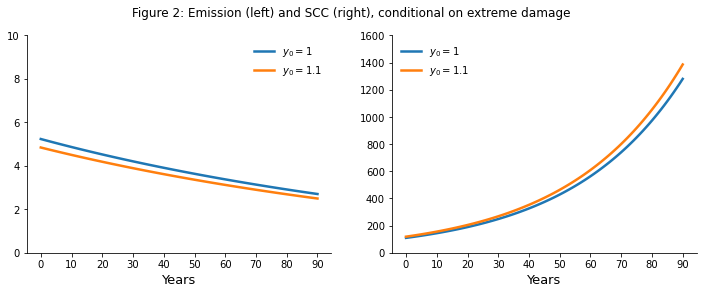

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(et_list[2], label=r'$y_0=1$', linewidth=2.5)
ax1.plot(et_list_new[2], label=r'$y_0=1.1$', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0, 10)

ax2.plot(SCCt_list[2], label=r'$y_0=1$', linewidth=2.5)
ax2.plot(SCCt_list_new[2], label=r'$y_0=1.1$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.legend(frameon=False)
ax2.set_ylim(0, 1600)


ax1.set_xticks(np.arange(0, 100, 10))
ax2.set_xticks(np.arange(0, 100, 10))

fig.suptitle('Figure 2: Emission (left) and SCC (right), conditional on extreme damage')

fig.savefig('../plots/extreme_damage.pdf')